# 

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [5]:
# Dropout 증가 + L2 + Dense 노드 축소
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Dense 노드 축소 + 정규화
    Dropout(0.4),  # Dropout 증가
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, verbose=1)

Epoch 1/20
1200/1200 [==============================] - 208s 169ms/step - loss: 0.4389 - accuracy: 0.8732 - val_loss: 0.5620 - val_accuracy: 0.7640
Epoch 2/20
1200/1200 [==============================] - 36s 30ms/step - loss: 0.2637 - accuracy: 0.9349 - val_loss: 0.5490 - val_accuracy: 0.8076
Epoch 3/20
1200/1200 [==============================] - 36s 30ms/step - loss: 0.2204 - accuracy: 0.9540 - val_loss: 0.7687 - val_accuracy: 0.6779
Epoch 4/20
1200/1200 [==============================] - 36s 30ms/step - loss: 0.1916 - accuracy: 0.9643 - val_loss: 0.3093 - val_accuracy: 0.9167
Epoch 5/20
1200/1200 [==============================] - 36s 30ms/step - loss: 0.1864 - accuracy: 0.9663 - val_loss: 0.3655 - val_accuracy: 0.8751
Epoch 6/20
1200/1200 [==============================] - 35s 30ms/step - loss: 0.1745 - accuracy: 0.9703 - val_loss: 0.2290 - val_accuracy: 0.9448
Epoch 7/20
1200/1200 [==============================] - 37s 30ms/step - loss: 0.1652 - accuracy: 0.9733 - val_loss: 0.4673

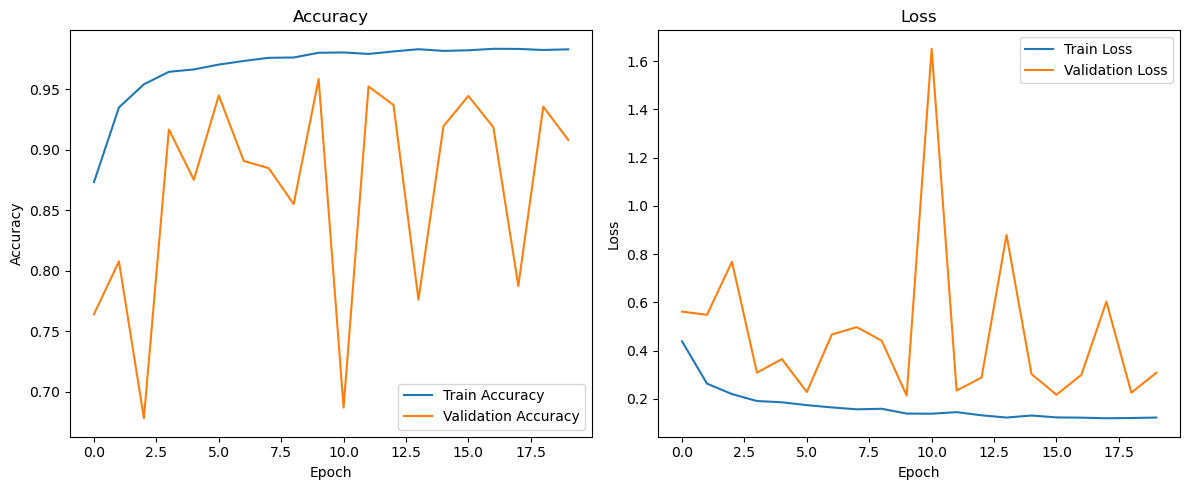

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/250616_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.86      0.95      0.91      4800
        open       0.95      0.85      0.90      4800

    accuracy                           0.90      9600
   macro avg       0.91      0.90      0.90      9600
weighted avg       0.91      0.90      0.90      9600



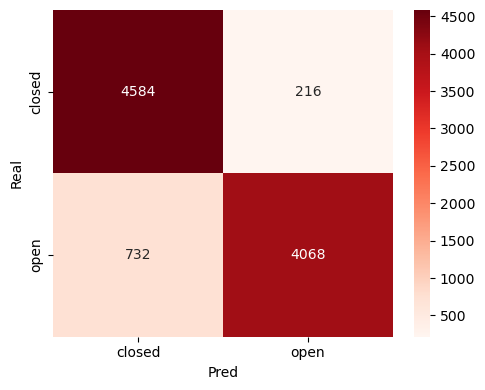

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/250616rc_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/250616con_mat.png")
plt.show()

In [9]:
os.makedirs("../../src/models/05_02Readjust_Model", exist_ok=True)
model.save("../../src/models/05_02Readjust_Model/readjusted_model.keras")

1/1 [==============================] - 0s 11ms/step
총 오답 샘플 수: 460


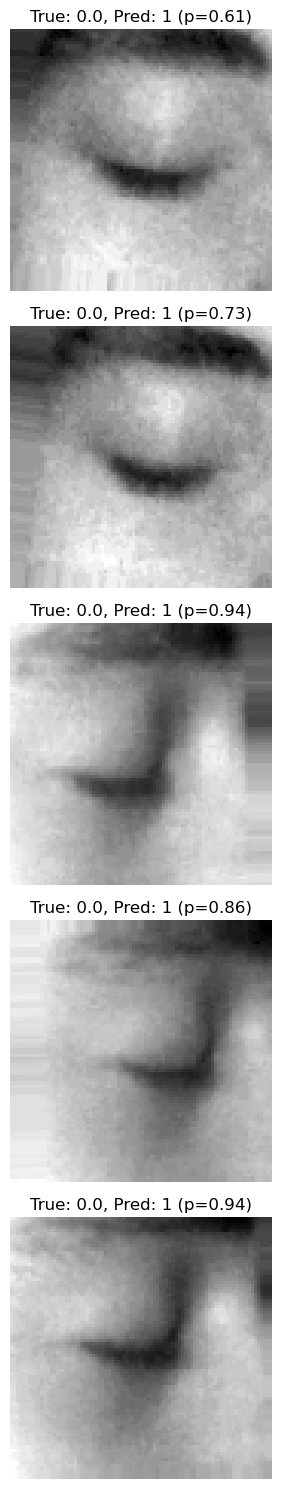

In [18]:
# 1) Generator 위치를 0으로 리셋
val_generator.reset()

wrong_images = []
wrong_labels = []
wrong_preds  = []
wrong_probs  = []

# 2) 모든 배치에 대해 predict & 오답 수집
steps = val_generator.samples // val_generator.batch_size + 1
for _ in range(steps):
    imgs, labs = next(val_generator)
    probs = model.predict(imgs).flatten()
    preds = (probs > 0.5).astype(int)

    # 틀린 인덱스 찾기 (배치 내 위치)
    errs = np.where(preds != labs)[0]
    for idx in errs:
        wrong_images.append(imgs[idx])
        wrong_labels.append(labs[idx])
        wrong_preds.append(preds[idx])
        wrong_probs.append(probs[idx])

# 3) 수집된 오답 개수 확인
print(f"총 오답 샘플 수: {len(wrong_images)}")

# 4) 상위 N개 시각화 (예: 5개만)
N = min(5, len(wrong_images))
plt.figure(figsize=(6, 3*N))
for i in range(N):
    ax = plt.subplot(N, 1, i+1)
    ax.imshow(wrong_images[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {wrong_labels[i]}, Pred: {wrong_preds[i]} (p={wrong_probs[i]:.2f})"
    )
plt.tight_layout()
plt.show()